# Generate random sampling of data

In [3]:
import math
import numpy as np
np.set_printoptions(threshold='nan')
import os
import sys
import cPickle as pickle
if sys.version_info[0] < 3:
    from Tkinter import Tk
else:
    from tkinter import Tk
from tkFileDialog import askopenfilename,askdirectory,asksaveasfile
import fnmatch
from sklearn.cluster import KMeans,DBSCAN


"""
============ Start ============
"""

# User defined
output = "/home/dgiles/Documents/KeplerLCs/output/Q8_output"
NumLCs = 10000

def loadData(filename):
    pathtofile = os.path.dirname(filename)
    f = open(filename,'r+') # show an "Open" dialog box and return the path to the selected file
    data = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        else:
            data.append(o)
    f.close()
    
    if len(data) == 1:
        data = data[0]
        
    return data

def randSample(NumLCs,output):
    print(output.replace(os.path.dirname(output)+"/",""))

    print("Importing data...")
    outputdata = loadData(output)

    files = [outputdata[i][0] for i in range(len(outputdata)) 
             if not np.isnan(outputdata[i][1:]).any() 
             and not np.isinf(outputdata[i][1:]).any()]
    
    data = np.array([outputdata[i][1:] for i in range(len(outputdata)) 
                     if not np.isnan(outputdata[i][1:]).any() 
                     and not np.isinf(outputdata[i][1:]).any()])
    
    numLists = int(math.ceil(len(files)/float(NumLCs)))
    print("Randomizing order and creating %s lists of %s samples per list..."%(numLists,NumLCs))
    randomInds = np.random.choice(range(len(files)), len(files), replace=False)
    
    randLists = [[files[i*NumLCs:(i+1)*NumLCs],data[i*NumLCs:(i+1)*NumLCs]] for i in range(numLists-1)]
    randLists.append([files[(numLists-1)*NumLCs:],data[(numLists-1)*NumLCs:]])

    print("Done.")
    
    return randLists,numLists

randLists,numLists=randSample(NumLCs,output)

"""
Variables Defined for use in Future Cells:
randLists contains:
    [(files,data),(files,data),...]
NumLCs
numLists
"""

Q8_output
Importing data...
Randomizing order and creating 17 lists of 10000 samples per list...
Done.


'\nVariables Defined for use in Future Cells:\nrandLists contains:\n    [(files,data),(files,data),...]\nNumLCs\nnumLists\n'

In [7]:
len(randLists[16][0])

7766

## Apply t-SNE dimensionallity reduction and plot for review

### TSNE with perplexity =1/3 total files, init='pca'

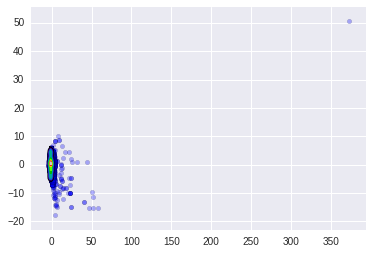

In [8]:
# from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import os
from multiprocessing import Pool
%matplotlib inline

def tsne_fit(randList):
    X = randList[1]
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    perplexity = len(X)/3
    tsne = TSNE(n_components=2,perplexity=perplexity,init='pca',verbose=False)
    tsne_fit=tsne.fit_transform(X)

    return tsne_fit


if numLists<48:
    useCPUs = numLists
else:
    useCPUs = 48
    
p = Pool(useCPUs)
tsne = p.map(tsne_fit,randLists)
p.close()

list1 = tsne[0]

x=list1[:,0]
y=list1[:,1]

with sns.axes_style("darkgrid"):
    sns.kdeplot(x, y,shade=False,cmap="nipy_spectral")
    plt.scatter(x, y,alpha=.3)

# Cluster the Data

In [10]:
""" 
Creates clusters from processed data for any number of dimensions using k-means or DBSCAN.

Requirement: Processed lightcurve data in a .pkl file. Elements in .pkl file should be
arranged as follows:
[str(filename),feature1,feature2,...,featureN]
"""
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
from sklearn.cluster import DBSCAN, KMeans
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
from mpl_toolkits.mplot3d import Axes3D,proj3d
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
from numbapro import cuda
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory, asksaveasfile
import fnmatch
import csv

root = Tk.Tk()
def reorganizeArray(X): 
    # This is just a transposition, could be accomplished by making X an np.array then transposing via X.T if prefered
    # TODO: Time the difference with large datasets (100,000+)
    return [[X[i][j] for i in range(len(X))] for j in range(len(X[0]))]

def loadData(filename):
    pathtofile = os.path.dirname(filename)
    f = open(filename,'r+') # show an "Open" dialog box and return the path to the selected file
    data = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        else:
            data.append(o)
    f.close()
    
    if len(data) == 1:
        data = data[0]
        
    return data

"""
DBSCAN Clustering
"""

from sklearn.neighbors import NearestNeighbors



def eps_est(data):
    # distance array containing all distances
    nbrs = NearestNeighbors(n_neighbors=1000, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    # Distance to 200th nearest neighbor, using 200th instead of 4th because: ... reasons
    distArr = distances[:,100]
    distArr.sort()
    pts = range(len(distArr))

    # The following looks for the first instance (past the mid point) where the mean of the following 50 points
    # is at least 5% greater than the mean of the previous 50 points.
    # Alternatively, perhaps a better method, we could consider the variance of the points and draw conclusions from that
    number = 50
    cutoff = 1.05
    for i in range(number,len(pts)-number):
        if np.mean(distArr[i+1:i+number])>=cutoff*np.mean(distArr[i-number:i-1]) and i>(len(pts)%2+len(pts))/2:

            dbEps = distArr[i]
            break
        
    # Estimating nneighbors by finding the number of pts. 
    # that fall w/in our determined eps for each point.

    count = np.zeros(len(pts))
    for i in pts:    
        for dist in distances[i]:
            if dist <= dbEps:
                count[i]+=1
    average = np.median(count)
    sigma = np.std(count)
    neighbors = average/2 # Divide by 2 for pts on the edges
    print("""
    Epsilon is in the neighborhood of %s, 
    with an average of %s neighbors within epsilon,
    %s neighbors in half circle (neighbors/2).
    """%(dbEps,average,neighbors))
    return dbEps,neighbors



def DBSCAN_clusters(data,eps,min_points=None):
    npdata = np.array(data)
    if min_points==None:
        est = DBSCAN(eps=eps)
    else:
        est = DBSCAN(eps=eps,min_samples=min_points)
    
    est.fit(npdata)
    clusters = est.labels_
    coreSampleIndices = est.core_sample_indices_
    
    return clusters, coreSampleIndices

def DBSCAN_cluster(files,data):
    dbEps,neighbors= eps_est(data)
    params = [dbEps,neighbors]
    print("Clustering data with DBSCAN...")
    clusterLabels,coreSampleIndices = DBSCAN_clusters(data,dbEps,neighbors)
    plotArray = [files,clusterLabels,data]
    print("Sorting...")
    centerIndex=coreSampleIndices[0]
    outlierIndices = [i for i in range(len(clusterLabels))if clusterLabels[i]==-1]
    outlierFiles = [files[i] for i in outlierIndices]
    numout = len(outlierFiles)
    numclusters = max(clusterLabels+1)
    tabbyInd = files.index(fnmatch.filter(files,'*8462852*')[0])
    if fnmatch.filter(files,'*8462852*')[0] in outlierFiles:
        print("Tabby has been found to be an outlier in DBSCAN.")
    else:
        print("Tabby has not been found to be an outlier in DBSCAN")
        
    print("There were %s clusters and %s total outliers"%(numclusters,numout))
    return clusterLabels,coreSampleIndices, params



"""
K-means Clustering
"""

def KMeans_clusters(data,nclusters):
    # Run KMeans, get clusters
    npdata = np.array(data)
    est = KMeans(n_clusters=nclusters)
    est.fit(npdata)
    clusters = est.labels_
    centers = est.cluster_centers_
    return clusters, centers

def outliers(data,clusters,centers,files):
    """
    Args:
    data - all the data
    clusters - the cluster labels from kmeans.
    centers - locations of the cluster centers
    
    Purpose:
    Separate out the data on the edge of the clusters which are the most likely outliers.
    """
    # Will try to stick to the following:
    # cluster i, lightcurve j, feature k
    nclusters = len(centers)
    
    """
    Initializing arrays
    """
    
    dataByCluster = []
    clusterIndices = []
    clusters = np.array(clusters)
    
    for i in range(min(clusters),max(clusters)+1):
        # Keeping track of which points get pulled into each cluster:
        clusterIndices.append([j[0] for j in enumerate(clusters) if j[1]==i])
        
        # Separating the cluster data out into their own arrays (w/in the cluster array)
        dataByCluster.append([data[j[1]] for j in enumerate(clusterIndices[i])])
            
    allTypical=[]
    allOutliers=[]

    for i in range(nclusters):
        """
        ========== Finding points outside of the cutoff ===========
        """
        sigma = np.std(dataByCluster[i])
        cutoff = 2*sigma
        """
            ==== Calculating distances to each point ====
        """
        # Calculate distances to each point in each cluster to the center of its cluster
        distFromCenter=[sum((pt-centers[i])**2)**.5 for pt in dataByCluster[i]]
        
        """
            ==== Finding outliers and the standard (defined by the closest to the center) ====
        """
        
        # returns cluster indices of the outliers and the typical lcs
        outliers=[j[0] for j in enumerate(distFromCenter) if j[1]>=cutoff]
        typical = [j[0] for j in enumerate(distFromCenter) if j[1]==min(distFromCenter)]

        clusters[outliers]=-1
        clusters[typical]=0
        
    return clusters

"""
============ Start ============
"""
        
"""--- Importing the relevant data ---"""
clusterType = raw_input('Which clustering method (kmeans or dbscan)? ')
if clusterType == 'KMeans' or clusterType == 'kmeans' or clusterType == 'Kmeans': 
    
    filesList = [randLists[i][0] for i in range(numLists)]
    dataList = [tsne[i] for i in range(numLists)]

    # nclusters can be obtained through the optimalK.py script 

    nclusters = 1
    outlierfiles = []
    plotArrays = []
    for i in enumerate (filesList):
        files = i[1]
        data = dataList[i[0]]
        clusters,centers=KMeans_clusters(data,nclusters)

        clusterLabels=outliers(data,clusters,centers,files)
        clusterLabels = np.array(clusterLabels)
        numout = len(clusterLabels[clusterLabels==-1])

        print("There were %s outliers in %s clusters"%(numout,nclusters))

        outlierfiles.append([files[i[0]] for i in enumerate(clusterLabels) if i[1]==-1])
        plotArrays.append([files,clusterLabels,data])
    print("Done.")
        
elif clusterType == 'DBSCAN' or clusterType =='dbscan':

    files = [i[1][0] for i in enumerate(dataTSNE)]
    data = [[i[1][1],i[1][2]] for i in enumerate(dataTSNE)]

    print("Clustering data...")
    clusterLabels,coreSampleIndices,params = DBSCAN_cluster(files,data)
    plotArray = [files,clusterLabels,data]
    print("Sorting...")
    centerIndex=coreSampleIndices[0]
    outlierfiles = [files[i[0]] for i in enumerate(clusterLabels) if i[1]==-1]
    print("Done.")

else:
    print("Only KMeans and DBSCAN are compatible with this program at this time.")
    sys.exit()


Which clustering method (kmeans or dbscan)? kmeans
There were 83 outliers in 1 clusters
There were 112 outliers in 1 clusters
There were 122 outliers in 1 clusters
There were 121 outliers in 1 clusters
There were 96 outliers in 1 clusters
There were 133 outliers in 1 clusters
There were 92 outliers in 1 clusters
There were 65 outliers in 1 clusters
There were 96 outliers in 1 clusters
There were 19 outliers in 1 clusters
There were 121 outliers in 1 clusters
There were 105 outliers in 1 clusters
There were 123 outliers in 1 clusters
There were 108 outliers in 1 clusters
There were 119 outliers in 1 clusters
There were 109 outliers in 1 clusters
There were 76 outliers in 1 clusters
Done.


In [19]:
plotArray=plotArrays[2]

kplr001569822-2011073133259_llc.fits


# Plot clusters (must be generated above)

In [15]:
import ast
import random
import numpy as np
np.set_printoptions(threshold='nan')
import scipy as sp
from scipy import stats
import pyfits
import math
# The order of the following is important, matplot.use('TkAgg') must be done before importing pyplot
import matplotlib
matplotlib.use('TkAgg')
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.cm as cmx
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec
import seaborn as sns
from multiprocessing import Pool,cpu_count
import sys
import os
import cPickle as pickle
if sys.version_info[0] < 3:
    import Tkinter as Tk
else:
    import tkinter as Tk
    
from tkFileDialog import askopenfilename,askdirectory
from numbapro import cuda

root = Tk.Tk()
root.wm_title("Scatter")

def read_kepler_curve(file):
    lc = pyfits.getdata(file)
    t = lc.field('TIME')
    f = lc.field('PDCSAP_FLUX')
    err = lc.field('PDCSAP_FLUX_ERR')
    f = f[np.isfinite(t)]
    t = t[np.isfinite(t)]
    t = t[np.isfinite(f)]
    f = f[np.isfinite(f)]
    
    nf = f / np.median(f)

    return t, nf, err

if __name__ == '__main__':
    """--- import light curve data ---"""
    pathtofits = '/home/dgiles/Documents/KeplerLCs/fitsFiles/Q8fitsfiles/'
    
    # The following needs to be generated in the cell above.
    files = plotArray[0]
    clusterLabels = plotArray[1]
    # data is an array containing each data point
    data = np.array(plotArray[2])
    
    cNorm  = colors.Normalize(vmin=0, vmax=max(clusterLabels))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')

    # tsneX has all the x-coordinates
    tsneX = data[:,0]
    # tsneY has all the y-coordinates
    tsneY = data[:,1]   
    outX = []
    outY = []
    files_out = []
    clusterX = []
    clusterY = []
    files_cluster = []
    
    for i in enumerate(data):
        if clusterLabels[i[0]] == -1:
            outX.append(i[1][0])
            outY.append(i[1][1])
            files_out.append(files[i[0]])
        else:
            clusterX.append(i[1][0])
            clusterY.append(i[1][1])
            files_cluster.append(files[i[0]])
    
    filesWpath = [pathtofits+files[i] for i in range(len(files))]
    numcpus = cpu_count()
    usecpus = numcpus*4
    p = Pool(usecpus)
    lc = p.map(read_kepler_curve,filesWpath)
    p.close()
    p.join()
    
    t=[lc[i][0] for i in range(len(lc))]
    nf=[lc[i][1] for i in range(len(lc))]

    lightcurveData=np.array([t,nf])
    
    del(lc)
    del(t)
    del(nf)
    del(numcpus)
    del(usecpus)
    del(filesWpath)
    """--- Organizing data and Labels ---"""
    tabbyCheck = fnmatch.filter(files,'*8462852*')
    if len(tabbyCheck)!=0:
        tabbyInd = files.index(tabbyCheck[0])
    else:
        tabbyInd = 0
    
    fig = Figure(figsize=(30,15))
    
    
    # a tk.DrawingArea
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.get_tk_widget().pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    # Toolbar to help navigate the data (pan, zoom, save image, etc.)
    toolbar = NavigationToolbar2TkAgg(canvas, root)
    toolbar.update()
    canvas._tkcanvas.pack(side=Tk.TOP, fill=Tk.BOTH, expand=1)
    
    gs = gridspec.GridSpec(2,6)
    
    with sns.axes_style("white"):
        # empty subplot for scattered data
        ax = fig.add_subplot(gs[0,:4])
        # empty subplot for lightcurves
        ax2 = fig.add_subplot(gs[1,:])
        # empty subplot for center detail
        ax3 = fig.add_subplot(gs[0,4:])
    
    def distance(point, event):
        """Return distance between mouse position and given data point

        Args:
            point (np.array): np.array of shape (3,), with x,y,z in data coords
            event (MouseEvent): mouse event (which contains mouse position in .x and .xdata)
        Returns:
            distance (np.float64): distance (in screen coords) between mouse pos and data point
        """
        assert point.shape == (2,), "distance: point.shape is wrong: %s, must be (2,)" % point.shape
        x2,y2 = ax.transData.transform((point[0],point[1]))

        return np.sqrt ((x2 - event.x)**2 + (y2 - event.y)**2)
    
    def calcClosestDatapoint(XT, event):
        """Calculate which data point is closest to the mouse position.
        
        Args:
            XT (np.array) - array of points, of shape (numPoints, 2)
            event (MouseEvent) - mouse event (containing mouse position)
        Returns:
            smallestIndex (int) - the index (into the array of points X) of the element closest to the mouse position
        """
        distances = [distance (XT[:,i], event) for i in range(XT.shape[1])]
        
        return np.argmin(distances)
    
    def drawData(X, index):
        # Plots the lightcurve of the point chosen
        ax2.cla()
        
        x=X[0][index]
        y=X[1][index]
        
        axrange=0.55*(max(y)-min(y))
        mid=(max(y)+min(y))/2
        yaxmin = mid-axrange
        yaxmax = mid+axrange
        if yaxmin < .95:
            if yaxmax > 1.05:
                ax2.set_ylim(yaxmin,yaxmax)
            else:
                ax2.set_ylim(yaxmin,1.05)
        elif yaxmax > 1.05:
            ax2.set_ylim(.95,yaxmax)
        else:
            ax2.set_ylim(.95,1.05)

        if files[index] in files_cluster:
            color = 'blue'
        else:
            color = 'red'
        ax2.plot(x, y, 'o',markeredgecolor='none', c=color, alpha=0.2)
        ax2.plot(x, y, '-',markeredgecolor='none', c=color, alpha=0.7)
        #ax2.set_title(files[index][:13],fontsize = 20)
        ax2.set_xlabel('Time (Days)',fontsize=22)
        ax2.set_ylabel(r'$\frac{\Delta F}{F}$',fontsize=30)
        
        fig.suptitle(files[index][:13],fontsize=30)
        
        canvas.draw()
        
    def annotatePt(XT, index):
        """Create popover label in 3d chart

        Args:
            X (np.array) - array of points, of shape (numPoints, 3)
            index (int) - index (into points array X) of item which should be printed
        Returns:
            None
        """
        x2, y2 = XT[index][0], XT[index][1]
        # Either update the position, or create the annotation
        if hasattr(annotatePt, 'label'):
            annotatePt.label.remove()
            annotatePt.emph.remove()
        if hasattr(annotatePt, 'emphCD'):
            annotatePt.emphCD.remove()

        # Get data point from array of points X, at position index
        annotatePt.label = ax.annotate( "",
            xy = (x2, y2), xytext = (x2+10, y2+10),
            arrowprops = dict(headlength=20,headwidth=20,width=6,shrink=.1,color='red'))
        annotatePt.emph = ax.scatter(x2,y2,marker='o',s=50,c='red')
        if files[index] in files_cluster:
            annotatePt.emphCD = ax3.scatter(x2,y2,marker='o',s=150,c='red')
        else:
            annotatePt.emphCD = ax.scatter(x2,y2,marker='o',s=50,c='red')
        canvas.draw()
    
    
    def onMouseClick(event, X):
        """Event that is triggered when mouse is clicked. Shows lightcurve for data point closest to mouse."""
        XT = np.array(reorganizeArray(X)) # array organized by feature, each in it's own array
        closestIndex = calcClosestDatapoint(XT, event)
        drawData(lightcurveData, closestIndex)
        
    def onMouseRelease(event, X):
        XT = np.array(reorganizeArray(X))
        closestIndex = calcClosestDatapoint(XT, event)
        annotatePt(X,closestIndex)
        #for centerIndex in centerIndices:
        #    annotateCenter(XT,centerIndex)
    
    def connect(X):
        if hasattr(connect,'cidpress'):
            fig.canvas.mpl_disconnect(connect.cidpress)
        if hasattr(connect,'cidrelease'):
            fig.canvas.mpl_disconnect(connect.cidrelease)
            
        connect.cidpress = fig.canvas.mpl_connect('button_press_event', lambda event: onMouseClick(event,X))
        connect.cidrelease = fig.canvas.mpl_connect('button_release_event', lambda event: onMouseRelease(event, X))
    
    def redraw():       
        # Clear the existing plots
        ax.cla()
        ax2.cla()
        ax3.cla()
        # Set those labels
        ax.set_xlabel("T-SNE X",fontsize=18)
        ax.set_ylabel("T-SNE Y",fontsize=18)
        # Scatter the data
        ax.scatter(outX, outY,c="black",s=30,cmap='jet')
        ax.hexbin(clusterX,clusterY,mincnt=5,bins="log",cmap="inferno",gridsize=35)
        
        hb = ax3.hexbin(clusterX,clusterY,mincnt=5,bins="log",cmap="inferno",gridsize=35)
        cb = fig.colorbar(hb)
        ax3.set_title("Center Density Detail")
        ax3.set_xlabel("T-SNE X",fontsize=18)
        ax3.set_ylabel("T-SNE Y",fontsize=18)
        
        
        #for centerIndex in centerIndices:
        #    annotateCenter(currentData1,centerIndex)
        
        if hasattr(redraw,'cidenter'):
                fig.canvas.mpl_disconnect(redraw.cidenter)
                fig.canvas.mpl_disconnect(redraw.cidexit)
        connect(data)
            
        annotatePt(data,tabbyInd)
        drawData(lightcurveData,tabbyInd)
        #fig.savefig('Plots/Q16_PCA_kmeans/Tabby.png')
        canvas.draw()
        
    print("Plotting.")
    
    redraw() # First draw, Tabby plotted
    canvas.show()
    
    def quit():
        print("Exitting.")
        root.quit()
        root.destroy()
        
    Tk.Button(root, text="Quit", command=quit).pack()
    
root.mainloop()

Plotting.
Exitting.


<IPython.core.display.Javascript object>


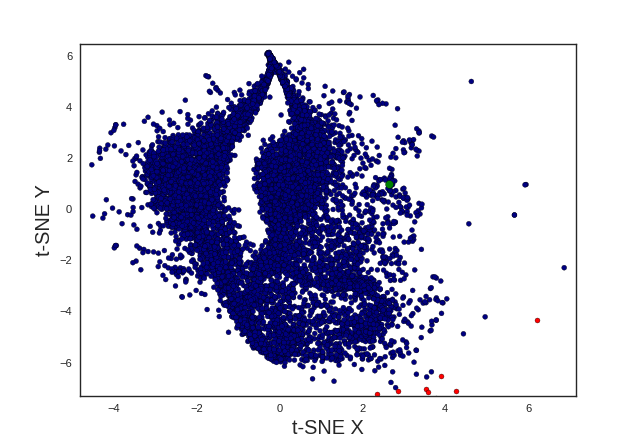

<IPython.core.display.Javascript object>


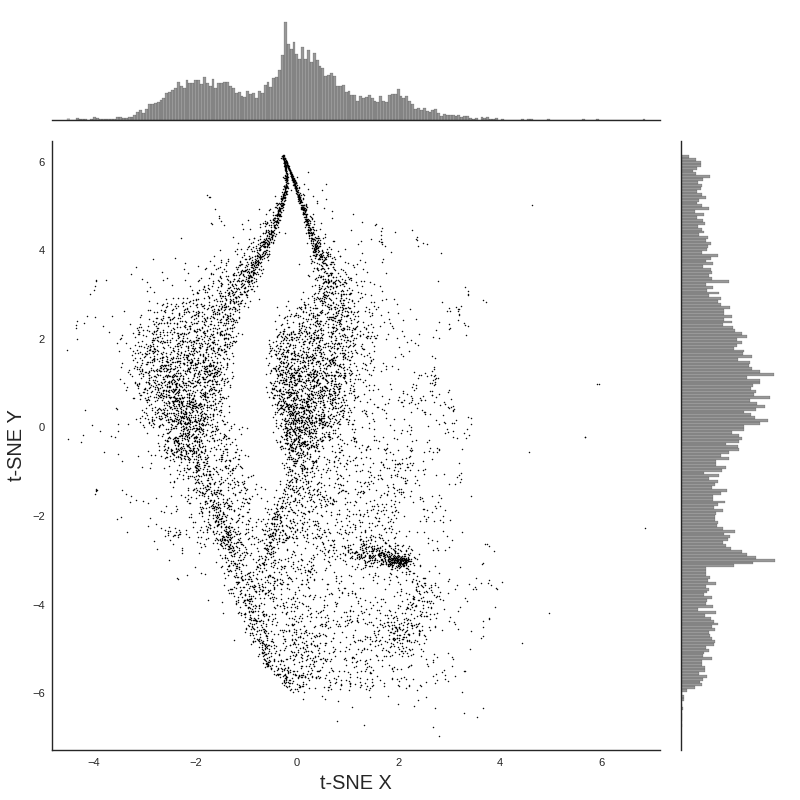

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



outX = []
outY = []
files_out = []
clusterX = []
clusterY = []
files_cluster = []
clusteredLabels = []

for i in enumerate(data):
    if clusterLabels[i[0]] == -1:
        outX.append(i[1][0])
        outY.append(i[1][1])
        files_out.append(files[i[0]])
    else:
        clusterX.append(i[1][0])
        clusterY.append(i[1][1])
        files_cluster.append(files[i[0]])
        clusteredLabels.append(clusterLabels[i[0]])
        
df = pd.DataFrame()
df['t-SNE_X'] = clusterX
df['t-SNE_Y'] = clusterY

cNorm  = colors.Normalize(vmin=0, vmax=max(clusteredLabels))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
           
with sns.axes_style("white"):

    plt.xlabel("t-SNE X",fontsize=18)
    plt.ylabel("t-SNE Y",fontsize=18)
    #plt.hexbin(clusterX,clusterY,mincnt=1,bins="log",cmap="inferno",gridsize=35)
    #plt.colorbar()
    plt.scatter(clusterX,clusterY,marker='o',c=scalarMap.to_rgba(clusteredLabels))
    plt.scatter(outX,outY,c="red")
    xmid = (max(clusterX)+min(clusterX))/2
    xrng = (max(clusterX)-min(clusterX))/2
    ymid = (max(clusterY)+min(clusterY))/2
    yrng = (max(clusterY)-min(clusterY))/2
    plt.scatter(data[tabbyInd][0],data[tabbyInd][1],c='green',s=50)
    plt.xlim(xmid-xrng*1.05,xmid+xrng*1.05)
    plt.ylim(ymid-yrng*1.05,ymid+yrng*1.05)
    g = sns.jointplot(x="t-SNE_X",y="t-SNE_Y",data=df,kind='scatter',color="black",stat_func=None,size=10,\
                      xlim=(xmid-xrng*1.05,xmid+xrng*1.05),ylim=(ymid-yrng*1.05,ymid+yrng*1.05),\
                      marginal_kws=dict(bins=200),\
                      joint_kws=dict(s=1))
    
    g.set_axis_labels("t-SNE X","t-SNE Y", fontsize=18)
    

